# Evaluación de segmentación

El objetivo de este Jupyter Notebook es implementar un sistema de segmentación que nos ayude a identificar sugus de sabor de piña. Evidentemente nuestro sistema segmentación no entiende de sabores si no de formas y colores. 

A lo largo de este Notebook comprenderemos los mecanismos utilizados para lograr nuestro propósito.

![Background](images/background.jpeg)

## Soluciones

A continuación cubriremos 2 soluciones diferentes para resolver nuestro caso de uso.  Nuestro dataset estará formado por 4 imágenes:

- image_1: Aparece 1 único sugus de sabor piña.
- image_2: Aparecen 1 sugus que es de naranja.
- image_3: Aparecen varios sugus sólo uno es de piña.
- image_4: Aparecen varios sugus, 2 de ellos son de piña

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

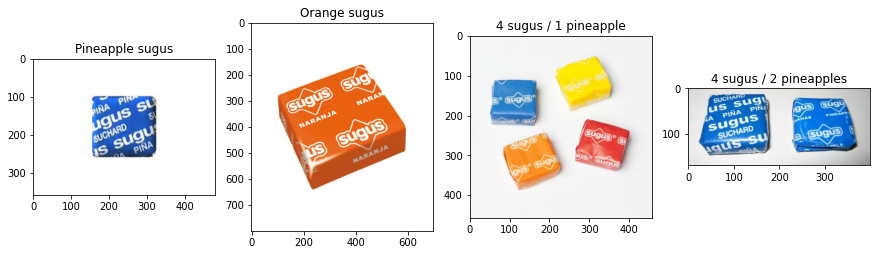

In [2]:
"""
These function is used to display as many images as attributes are passed. It's useful to simplify our code.
"""
def display_images(index,attrs):
    _,axes = plt.subplots(1,len(attrs),figsize=(15,15))
    for i in range(0,len(attrs)):
        fig = axes[i].imshow(items[index][attrs[i]], cmap='gray')
        axes[i].set_title(f'{titles[index]} ({attrs[i]}])')

"""
The items variable is an array that contains one entry (a map) per each Image. These maps will be used to store the different created
imaged during the segmentation process. The below pswudocode represents the stored information for each image.

items = [
   {
     "original" - BGR image
     "img_rgb"  - RGB image
     "gray"     - Image in grasyscale
     "img_r"    - Red channel of the image
     "img_g"    - Green channel of the image
     "img_b"    - Blue channel of the image
     "mask"     - Mak used to calculate the threshold
     "thresh"   - Threshold calculated from the mask and applying type THRESH_BINARY_INV
     "labels"   - It contains the different segments of the image after applying the threshold
     "output"   - The output image that contains the segmentations
   }

]
"""
images_name=['image_1.jpeg','image_2.jpeg','image_3.jpeg','image_4.jpeg']
titles=['Pineapple sugus','Orange sugus','4 sugus / 1 pineapple','4 sugus / 2 pineapples']
items=[]

"""
The below loop displays the input images in our dataset
"""
_,axes = plt.subplots(1,4,figsize=(15,15))
for i in range(0,4):
    img = cv.imread(f'images/{images_name[i]}')
    items.append({'original':img})
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    items[i]['img_rgb']=img_rgb
    fig = axes[i].imshow(items[i]['img_rgb'])
    axes[i].set_title(titles[i])

### Solución 1

Esta es la solución definitiva elegida para solucionar nuestro problema. Su implementación será explicada en los siguientes pasos

###  Paso 1 - Escalas de colores para las imágenes

Obtenemos la tonalidad de la imagen para los diferentes canales. Esto nos servirá para darnos cuenta que imagen de todas tenemos que utilizar para ser más precisos en nuestro sistema de segmentación. 

Teniendo en cuenta que buscamos identificar los sugus de sabor de piña, que son de color azul.

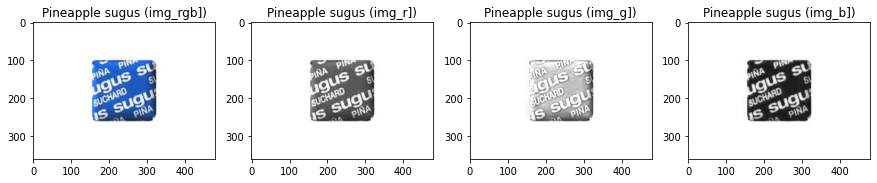

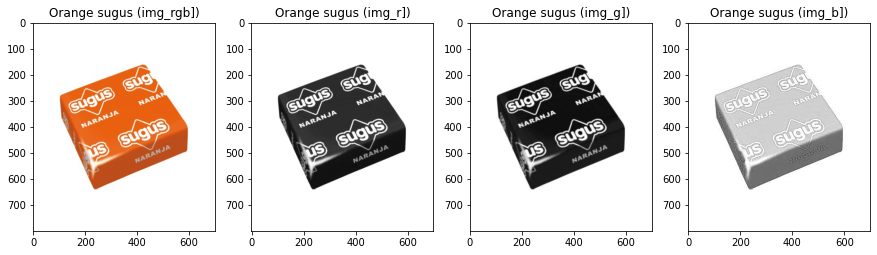

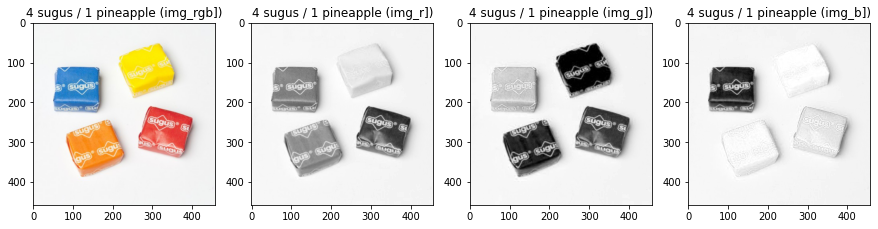

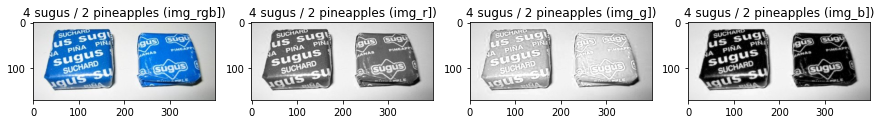

In [3]:
for i in range(0,4):
    img=items[i]['original']
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    items[i]['gray']=gray
    g, r, b = cv.split(img)
    items[i]['img_r'] = r
    items[i]['img_g'] = g
    items[i]['img_b'] = b
    display_images(i, ['img_rgb','img_r','img_g','img_b'])

Efectivamente si nos fijamos en la cuarta representación de cada una de las imagenes podemos observar que los sugus de sabor de piña aparecen en un tono de gris más oscuro.

###  Paso 2 - Obtención de la máscara y el threshold aplicando erosión y dilatación

A continuación vamos a obtener la máscara necesaria para obtener el threshold de nuestra imagen. Para ello, primero aplicaremos una dilatación y posteriormente una erosión de la imagen correspondiente al canal azul.

En concreto en nuestro caso, es importante que el número de veces que aplicamos la erosión sea el suficiente para que las letras que aparecen en el envoltorio se difuminen, obteniendo un threshoold que será representado como un cuadrado. 

Una vez hemos obtenido la máscara, calcularemos el threshold, en este caso jugaremos con la tonalidad que tienen los sugus de piña (las tonalidades más altas en la escala azul) para descartar de nuestro threshold aquellos elementos que no nos interesan.

* Nota: Un posible problema si utilizásemos un número de iteraciones para la erosión demasiado elevado sería que las cajas correspondientes a los sugus serían demasiado grandes y poco precisas.


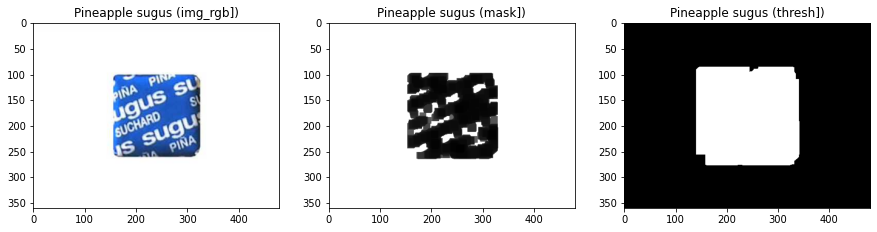

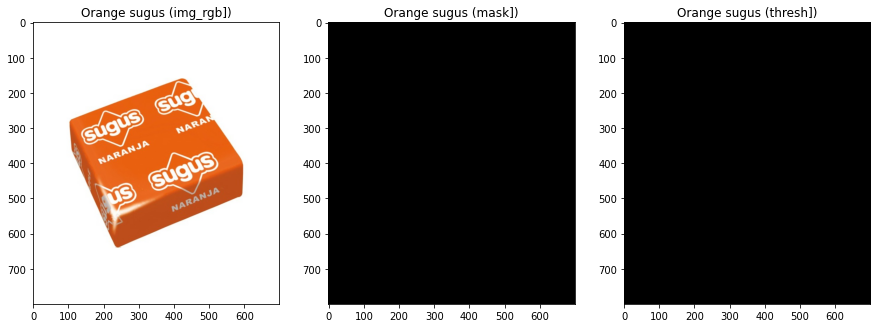

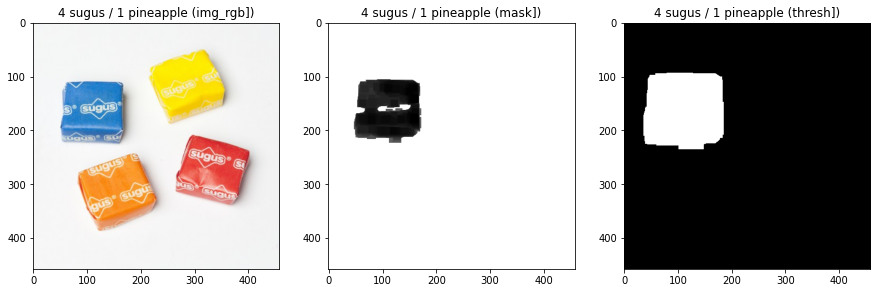

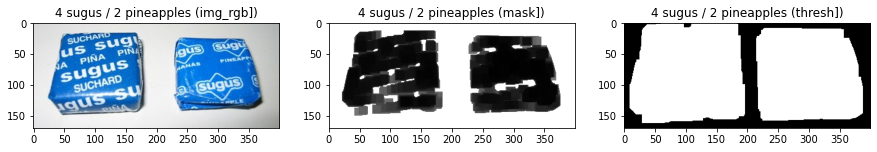

In [4]:
kernel = np.ones((5,5), np.float32)/1
for i in range(0,4):
    mask = cv.dilate(items[i]['img_b'], kernel, iterations=1)
    mask = cv.erode(mask, kernel, iterations=3, borderType=cv.BORDER_DEFAULT)
    msk=mask+1
    mask[mask>120]=255
    items[i]['mask']=mask
    ret, thresh = cv.threshold(mask,150,255,cv.THRESH_BINARY_INV)
    thresh = cv.dilate(thresh, kernel, iterations=6)
    items[i]['thresh']=thresh
    display_images(i, ['img_rgb','mask','thresh'])

Como podemos observar en las figuras anteriores la imagen que muestra el threshold nos indica que ya ha identificado los sugus de piña

###  Paso 3 - Obtención de los segmentos encontrados en cada uno de los thresholds

La función connectedComponents de la librería cv2 nos permite identificar los diferentes segmentos que forman nuestra imagen.

In [5]:
for i in range(0,4):
    img_thresh=items[i]['thresh']
    _, labels = cv.connectedComponents(img_thresh)
    unique, counts = np.unique(labels, return_counts=True)
    print("[INFO] {} found segments".format(len(labels) - 1))
    items[i]['labels']=labels

[INFO] 359 found segments
[INFO] 799 found segments
[INFO] 457 found segments
[INFO] 169 found segments


###  Paso 4 - Aplicamos los segmentos

A continuación vamos a mostrar de dos modos diferentes la segmentación de nuestras imágenes:
- Marcando con un color los sugus de sabor a piña.
- Rodeando con una circunferencia y enumerando cada uno de los sugus de sabor a piña que hemos encontrado.

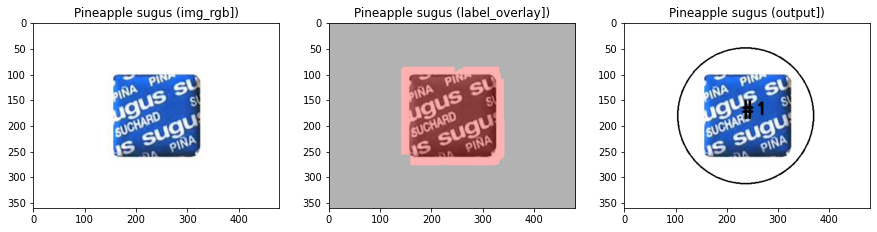

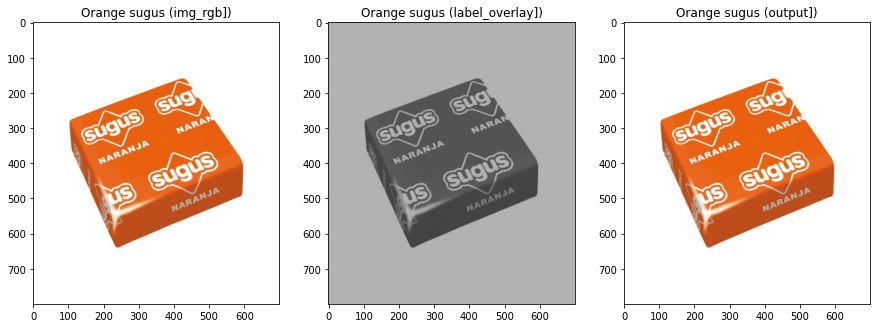

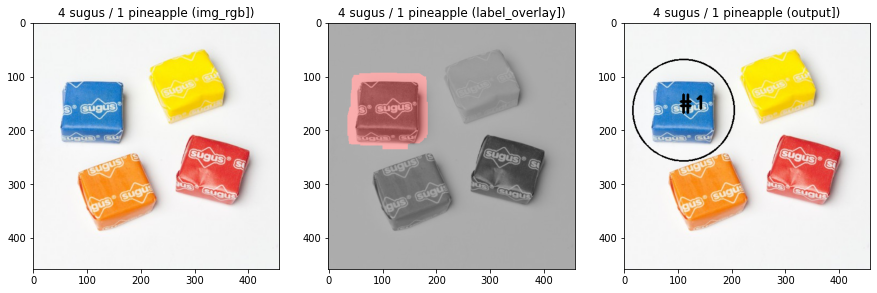

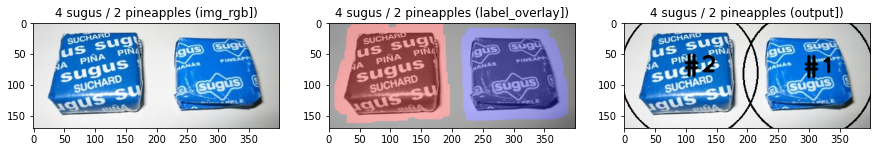

In [6]:
import imutils
from skimage.color import label2rgb

for i in range(0,4):
    labels = items[i]['labels']
    output=items[i]['img_rgb'].copy()
    thresh = items[i]['thresh']
    label_index=0
    
    for label in np.unique(labels):
        if label == 0:
            continue
        cnts = cv.findContours(thresh.copy(), cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        ((x, y), r) = cv.minEnclosingCircle(cnts[label_index])
        x=int(x)
        y=int(y)
        cv.circle(output, (x, y), int(r), (0, 0, 0), 2)
        cv.putText(output, "#{}".format(label), (x - 10, y), cv.FONT_HERSHEY_PLAIN, 2.6, (0,0,0), 4)
        label_index+=1
    items[i]['label_overlay'] = label2rgb(labels, image=items[i]['img_rgb'].copy(), bg_label=0)
    items[i]['output']=output
    display_images(i,['img_rgb','label_overlay','output'])

## Solución 2

Esta solución fue realizada para obtener un problema diferente del actual. Y que realmente su alcance es mucho más limitado pero me sirvió como punto de entrada par aaprender como funcionan los algoritmos de segmentación. La estrategia incial fue muy parecida, apoyarme en el canal BLUE pero los resultados como puedn observarse a continuación son de menor calidad.

Intenté encontrar los bordes usando la utilidad Cany de opencv y los contornos, además de utilizar un threshold, pero
como mencionaba anteriormente faltan muchos detalles que son los que dan mayor calidad a la solución anterior, tales como el uso de dilataciones y erosiones, filtrado más detallado, obtención de segmentos.

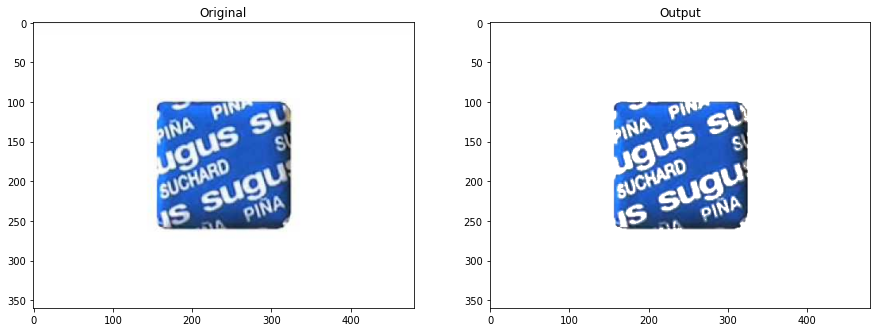

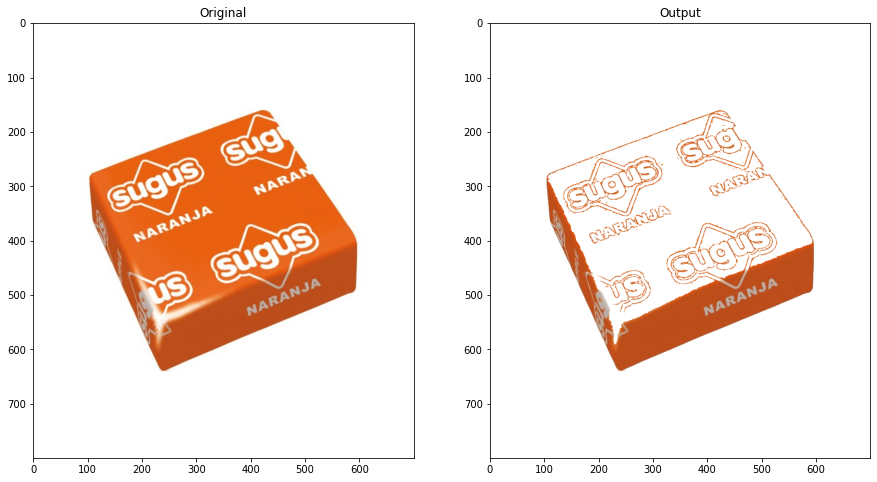

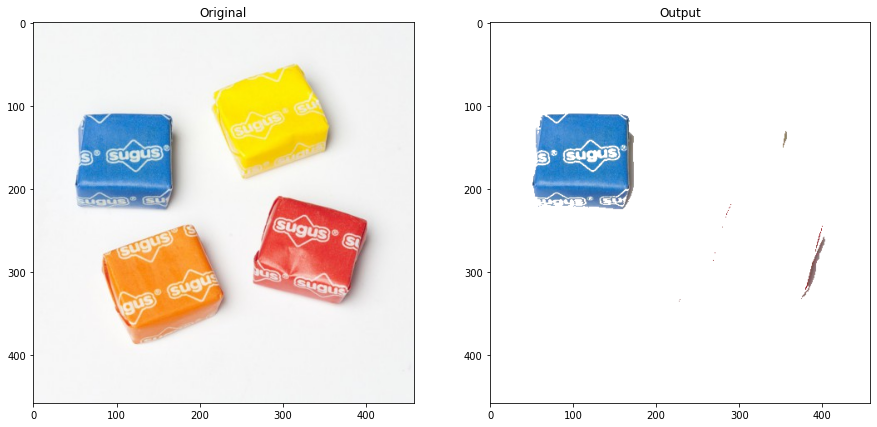

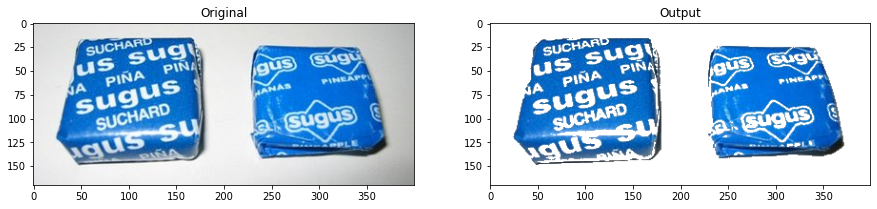

In [7]:
for i in range(0,4):
    img = cv.imread(f'images/{images_name[i]}')
    img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    b = cv.split(img)[2]
    ret,thresh = cv.threshold(b, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    canny = cv.Canny(thresh, 0,255)
    contours, hierarchies = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    _,(ax0,ax1) = plt.subplots(1,2,figsize=(15,15))
    ax0.set_title('Original')
    ax0.imshow(img_color)
    cv.drawContours(
        image=img_color,
        contours=contours, 
        contourIdx=-1, color=(255,255,255),thickness=-1
    )
    ax1.set_title('Output')
    ax1.imshow(img_color)

### Notas

Soy consciente de que la parte de validar los resultados obtenidos usando ground truths no se ha realizado, y que esto forma  parte de uno de los items de la rúbrica. Es algo que por motivos personales no he tenido tiempo de completar, pero que seguiré trabajando en ello para comprender el proceso completo.

